# Imports

In [ ]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.genmod.families import Poisson
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.model_selection import cross_validate, KFold, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import make_scorer, mean_absolute_error, root_mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
import warnings
from scipy.stats import loguniform
warnings.filterwarnings('ignore')

# Data Loading

In [ ]:
def load_bike_sharing_data(url):
    """
    Downloads and extracts the Bike Sharing Dataset from a given URL.

    Parameters:
    - url (str): URL to the ZIP file containing the dataset.

    Returns:
    - data (pd.DataFrame): Loaded hourly bike sharing data.
    """
    import urllib.request
    import zipfile
    import io

    print("Downloading and extracting the Bike Sharing Dataset...")
    response = urllib.request.urlopen(url)
    zip_file = zipfile.ZipFile(io.BytesIO(response.read()))
    zip_file.extractall()
    print("Download and extraction complete.\n")

    # Load the hourly dataset
    data = pd.read_csv('hour.csv')
    return data

# Preprocessing

In [ ]:
def create_preprocessing_pipeline():
    """
    Creates a preprocessing pipeline that encodes categorical variables
    and scales numerical features.

    Returns:
    - preprocessing_pipeline (ColumnTransformer): Preprocessing steps.
    """
    # Define categorical and numerical columns
    categorical_cols = ['season', 'weathersit', 'mnth', 'hr', 'weekday', 'workingday', 'holiday']
    numerical_cols = ['temp', 'atemp', 'hum', 'windspeed']

    # Preprocessing for numerical features
    numerical_transformer = StandardScaler()

    # Preprocessing for categorical features
    categorical_transformer = OneHotEncoder(drop='first', sparse_output=False)

    # Combine preprocessing steps
    preprocessing_pipeline = ColumnTransformer(
        transformers=[
            ('num', numerical_transformer, numerical_cols),
            ('cat', categorical_transformer, categorical_cols)
        ]
    )

    return preprocessing_pipeline

# Compatibility Class

In [ ]:
class StatsModelsPoissonRegressor(BaseEstimator, RegressorMixin):
    """
    Custom estimator that wraps Statsmodels Poisson GLM with regularization,
    compatible with scikit-learn's API.

    Parameters:
    - alpha (float): Regularization strength (0 for non-regularized).
    - L1_wt (float): Weight between L1 (Lasso) and L2 (Ridge) regularization.
                      0.0 for Ridge, 1.0 for Lasso, and between 0.0 and 1.0 for Elastic Net.
    - fit_intercept (bool): Whether to include an intercept.
    - maxiter (int): Maximum number of iterations for optimization.
    - method (str): Optimization method ('elastic_net').
    """
    def __init__(self, alpha=0.0, L1_wt=0.0, fit_intercept=True, maxiter=100, method='elastic_net'):
        self.alpha = alpha
        self.L1_wt = L1_wt
        self.fit_intercept = fit_intercept
        self.maxiter = maxiter
        self.method = method
        self.model_ = None
        self.params_ = None

    def fit(self, X, y):
        """
        Fits the Poisson GLM model with regularization.

        Parameters:
        - X (array-like): Feature matrix.
        - y (array-like): Target vector.

        Returns:
        - self: Fitted estimator.
        """
        if self.fit_intercept:
            X = sm.add_constant(X, has_constant='add')

        poisson_model = sm.GLM(y, X, family=Poisson())
        try:
            if self.alpha == 0.0:
                # Non-regularized model
                self.model_ = poisson_model.fit()
            else:
                # Regularized model
                self.model_ = poisson_model.fit_regularized(
                    method=self.method,
                    L1_wt=self.L1_wt,
                    alpha=self.alpha,
                    maxiter=self.maxiter
                )
            self.params_ = self.model_.params
        except Exception as e:
            print(f"Model fitting failed: {e}")
            self.params_ = np.full(X.shape[1], np.nan)
        return self

    def predict(self, X):
        """
        Generates predictions using the fitted model.

        Parameters:
        - X (array-like): Feature matrix.

        Returns:
        - y_pred (array-like): Predicted values.
        """
        if self.fit_intercept:
            X = sm.add_constant(X, has_constant='add')

        linear_pred = np.dot(X, self.params_)
        return np.exp(linear_pred)

    def get_params(self, deep=True):
        """
        Retrieves the parameters of the estimator.

        Returns:
        - params (dict): Parameter names mapped to their values.
        """
        return {
            'alpha': self.alpha,
            'L1_wt': self.L1_wt,
            'fit_intercept': self.fit_intercept,
            'maxiter': self.maxiter,
            'method': self.method
        }

    def set_params(self, **params):
        """
        Sets the parameters of the estimator.

        Parameters:
        - params (dict): Parameter names mapped to their new values.

        Returns:
        - self: Updated estimator.
        """
        for key, value in params.items():
            setattr(self, key, value)
        return self

# Model Definition

In [ ]:
def define_models():
    """
    Defines four Poisson regression models with different regularization settings.

    Returns:
    - models (dict): Dictionary mapping model names to their instantiated estimators.
    """
    model_types = {
        'Non-Regularized': {'alpha': 0.0, 'L1_wt': 0.0, 'method': 'elastic_net'},
        'Ridge': {'alpha': 1.0, 'L1_wt': 0.0, 'method': 'elastic_net'},
        'Lasso': {'alpha': 1.0, 'L1_wt': 1.0, 'method': 'elastic_net'},
        'Elastic Net': {'alpha': 1.0, 'L1_wt': 0.5, 'method': 'elastic_net'}
    }

    models = {}
    for name, params in model_types.items():
        models[name] = StatsModelsPoissonRegressor(
            alpha=params['alpha'],
            L1_wt=params['L1_wt'],
            fit_intercept=True,
            maxiter=100,
            method=params['method']
        )

    return models

# Scoring Function

In [ ]:
def poisson_deviance(y_true, y_pred):
    """
    Calculate the Poisson deviance.

    Parameters:
    - y_true (array-like): True target values.
    - y_pred (array-like): Predicted target values.

    Returns:
    - deviance (float): Poisson deviance.
    """
    y_pred = np.maximum(y_pred, 1e-10)  # Prevent log(0)
    deviance = 2 * np.sum(y_true * np.log(y_true / y_pred) - (y_true - y_pred))
    return deviance

In [ ]:
def root_poisson_deviance(y_true, y_pred):
    """
    Calculate the Root Poisson Deviance.

    Parameters:
    - y_true (array-like): True target values.
    - y_pred (array-like): Predicted target values.

    Returns:
    - root_deviance (float): Root Poisson Deviance.
    """
    deviance = poisson_deviance(y_true, y_pred)
    root_deviance = np.sqrt(deviance / len(y_true))
    return root_deviance

In [ ]:
def create_scorers():
    """
    Creates custom scoring functions for cross-validation.

    Returns:
    - scorers (dict): Dictionary of scoring functions.
    """
    rmse_scorer = make_scorer(root_mean_squared_error, greater_is_better=False)  # Lower RMSE is better
    mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)       # Lower MAE is better
    rpd_scorer = make_scorer(root_poisson_deviance, greater_is_better=False)     # Lower RPD is better

    return {
        'RMSE': rmse_scorer,
        'MAE': mae_scorer,
        'RPD': rpd_scorer
    }

# Nested CV

In [ ]:
def perform_nested_cross_validation(preprocessing_pipeline, model, param_grids, param_distributions, X, y,
                                    outer_cv, inner_cv, search_method, scorers):
    """
    Performs nested cross-validation with specified search method for hyperparameter tuning.

    Parameters:
    - preprocessing_pipeline (ColumnTransformer): Preprocessing steps.
    - model (Estimator): The model to evaluate.
    - param_grids (dict): Hyperparameter grids for GridSearchCV.
    - param_distributions (dict): Hyperparameter distributions for RandomizedSearchCV.
    - X (pd.DataFrame): Feature matrix.
    - y (pd.Series): Target vector.
    - outer_cv (object): Outer cross-validation strategy.
    - inner_cv (object): Inner cross-validation strategy for hyperparameter tuning.
    - search_method (str): 'grid' or 'random'.
    - scorers (dict): Dictionary of scoring functions.

    Returns:
    - cv_results (dict): Dictionary containing test scores for each metric.
    """
    # Create a Pipeline with preprocessing and the model
    pipeline = Pipeline([
        ('preprocessing', preprocessing_pipeline),
        ('model', model)
    ])

    # Initialize the search method
    if search_method == 'grid':
        search = GridSearchCV(
            estimator=pipeline,
            param_grid=param_grids,
            scoring=scorers,
            refit='RMSE',  # Refitting based on RMSE
            cv=inner_cv,
            n_jobs=-1
        )
    elif search_method == 'random':
        search = RandomizedSearchCV(
            estimator=pipeline,
            param_distributions=param_distributions,
            n_iter=20,  # Number of parameter settings sampled
            scoring=scorers,
            refit='RMSE',
            cv=inner_cv,
            random_state=42,
            n_jobs=-1
        )
    else:
        raise ValueError("Invalid search method. Choose from 'grid' or 'random'.")

    # Perform cross-validation
    cv_results = cross_validate(
        estimator=search,
        X=X,
        y=y,
        cv=outer_cv,
        scoring=scorers,
        return_train_score=False
    )

    return cv_results

In [ ]:
def aggregate_results(cv_results_dict):
    """
    Aggregates cross-validation results into a DataFrame.

    Parameters:
    - cv_results_dict (dict): Dictionary mapping model names to their cross-validation results.

    Returns:
    - results_df (pd.DataFrame): DataFrame containing average metrics for each model.
    """
    metrics = ['RMSE', 'MAE', 'RPD']
    model_names = list(cv_results_dict.keys())
    results_df = pd.DataFrame(index=metrics, columns=model_names)

    for model_name, cv_results in cv_results_dict.items():
        avg_rmse = -cv_results['test_RMSE'].mean()    # Negate because lower is better
        avg_mae = -cv_results['test_MAE'].mean()      # Negate because lower is better
        avg_rpd = -cv_results['test_RPD'].mean()      # Negate because lower is better

        results_df.loc['RMSE', model_name] = avg_rmse
        results_df.loc['MAE', model_name] = avg_mae
        results_df.loc['RPD', model_name] = avg_rpd

    return results_df

# Plotting

In [ ]:
def plot_grouped_bar_chart(results):
    """
    Plots a grouped bar chart of the evaluation metrics for each model.

    Parameters:
    - results (pd.DataFrame): DataFrame containing average metrics for each model.
    """
    # Melt the DataFrame
    results_melted = results.reset_index().melt(id_vars='index', var_name='Model', value_name='Value')
    results_melted.rename(columns={'index': 'Metric'}, inplace=True)

    # Set plot style
    sns.set(style="whitegrid")

    # Initialize the figure
    plt.figure(figsize=(18, 10))

    # Create a grouped barplot with models as hues and metrics on x-axis
    sns.barplot(data=results_melted, x='Metric', y='Value', hue='Model')

    # Add title and labels
    plt.title('Nested Cross-Validated Metrics by Model Type', fontsize=20)
    plt.ylabel('Metric Value', fontsize=16)
    plt.xlabel('Metrics', fontsize=16)
    plt.legend(title='Model Type', fontsize=12, title_fontsize=14)

    # Annotate bars with values
    for container in plt.gca().containers:
        plt.bar_label(container, fmt='%.2f', fontsize=12)

    # Show the plot
    plt.tight_layout()
    plt.show()

# Execution

In [ ]:
def main(search_method='grid'):
    """
    Main function to execute the workflow.

    Parameters:
    - search_method (str): 'grid' or 'random' to specify the hyperparameter search method.
    """
    # Validate search_method
    if search_method not in ['grid', 'random']:
        raise ValueError("Invalid search method. Choose from 'grid' or 'random'.")

    # 1. Load the Bike Sharing dataset
    dataset_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00275/Bike-Sharing-Dataset.zip"
    data = load_bike_sharing_data(dataset_url)

    # 2. Explore the data
    print("Dataset Preview:")
    display(data.head())
    print("\n")

    print("Dataset Information:")
    data_info = data.info()
    print(data_info)
    print("\n")

    print("Summary Statistics:")
    display(data.describe())
    print("\n")

    # 3. Preprocess the data
    print("Preprocessing the data...")
    preprocessing_pipeline = create_preprocessing_pipeline()

    # Define the target variable and feature matrix
    y = data['cnt']  # 'cnt' is the count of total rental bikes including both casual and registered
    # Drop columns not needed for modeling
    X = data.drop(['instant', 'dteday', 'casual', 'registered', 'cnt'], axis=1)

    print("Preprocessing complete.\n")

    # 4. Define models
    models = define_models()

    # 5. Define scorers
    scorers = create_scorers()

    # 6. Define cross-validation strategies
    outer_cv = KFold(n_splits=5, shuffle=True, random_state=42)
    inner_cv = KFold(n_splits=3, shuffle=True, random_state=42)

    # 7. Define Parameter Grids and Distributions for each Model Type
    param_grids = {
        'Non-Regularized': {
            'model__alpha': [0.0],
            'model__L1_wt': [0.0]
        },
        'Ridge': {
            'model__alpha': [0.01, 0.1, 1.0, 10.0, 100.0],
            'model__L1_wt': [0.0]
        },
        'Lasso': {
            'model__alpha': [0.01, 0.1, 1.0, 10.0, 100.0],
            'model__L1_wt': [1.0]
        },
        'Elastic Net': {
            'model__alpha': [0.01, 0.1, 1.0, 10.0, 100.0],
            'model__L1_wt': [0.3, 0.5, 0.7]
        }
    }

    param_distributions_random = {
        'Non-Regularized': {
            'model__alpha': [0.0],
            'model__L1_wt': [0.0]
        },
        'Ridge': {
            'model__alpha': loguniform(0.01, 100.0),
            'model__L1_wt': [0.0]
        },
        'Lasso': {
            'model__alpha': loguniform(0.01, 100.0),
            'model__L1_wt': [1.0]
        },
        'Elastic Net': {
            'model__alpha': loguniform(0.01, 100.0),
            'model__L1_wt': [0.3, 0.5, 0.7]
        }
    }

    # 8. Perform Nested Cross-Validation for each Model Type
    cv_results_dict = {}
    for model_name, model in models.items():
        print(f"Starting nested cross-validation for {model_name} model...")
        # Select parameter grid or distributions based on search_method
        if search_method == 'grid':
            param_grid = param_grids[model_name]
            param_distribution = None  # Not used
        elif search_method == 'random':
            param_grid = None  # Not used
            param_distribution = param_distributions_random[model_name]

        try:
            cv_results = perform_nested_cross_validation(
                preprocessing_pipeline=preprocessing_pipeline,
                model=model,
                param_grids=param_grid,
                param_distributions=param_distribution,
                X=X,
                y=y,
                outer_cv=outer_cv,
                inner_cv=inner_cv,
                search_method=search_method,
                scorers=scorers
            )
            cv_results_dict[model_name] = cv_results
            print(f"Nested cross-validation for {model_name} model complete.\n")
        except Exception as e:
            print(f"An error occurred during nested cross-validation for {model_name}: {e}\n")

    # 9. Aggregate results
    results_df = aggregate_results(cv_results_dict)

    # 10. Display the results
    print("Nested Cross-Validation Results:")
    display(results_df)
    print("\n")

    # 11. Plot the results
    plot_grouped_bar_chart(results_df)

Download and extraction complete.

Dataset Preview:


,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1




Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     17379 non-null  int64  
 1   dteday      17379 non-null  object 
 2   season      17379 non-null  int64  
 3   yr          17379 non-null  int64  
 4   mnth        17379 non-null  int64  
 5   hr          17379 non-null  int64  
 6   holiday     17379 non-null  int64  
 7   weekday     17379 non-null  int64  
 8   workingday  17379 non-null  int64  
 9   weathersit  17379 non-null  int64  
 10  temp        17379 non-null  float64
 11  atemp       17379 non-null  float64
 12  hum         17379 non-null  float64
 13  windspeed   17379 non-null  float64
 14  casual      17379 non-null  int64  
 15  registered  17379 non-null  int64  
 16  cnt         17379 non-null  int64  
dtypes: float64(4), int64(12), object(1)
memory usage: 2.3+ MB
None


Summary Statistics:

,instant,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
count,17379.0000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000
mean,8690.0000,2.501640,0.502561,6.537775,11.546752,0.028770,3.003683,0.682721,1.425283,0.496987,0.475775,0.627229,0.190098,35.676218,153.786869,189.463088
std,5017.0295,1.106918,0.500008,3.438776,6.914405,0.167165,2.005771,0.465431,0.639357,0.192556,0.171850,0.192930,0.122340,49.305030,151.357286,181.387599
min,1.0000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,4345.5000,2.000000,0.000000,4.000000,6.000000,0.000000,1.000000,0.000000,1.000000,0.340000,0.333300,0.480000,0.104500,4.000000,34.000000,40.000000
50%,8690.0000,3.000000,1.000000,7.000000,12.000000,0.000000,3.000000,1.000000,1.000000,0.500000,0.484800,0.630000,0.194000,17.000000,115.000000,142.000000
75%,13034.5000,3.000000,1.000000,10.000000,18.000000,0.000000,5.000000,1.000000,2.000000,0.660000,0.621200,0.780000,0.253700,48.000000,220.000000,281.000000
max,17379.0000,4.000000,1.000000,12.000000,23.000000,1.000000,6.000000,1.000000,4.000000,1.000000,1.000000,1.000000,0.850700,367.000000,886.000000,977.000000




Preprocessing the data...
Preprocessing complete.

Starting nested cross-validation for Non-Regularized model...
Nested cross-validation for Non-Regularized model complete.

Starting nested cross-validation for Ridge model...
Nested cross-validation for Ridge model complete.

Starting nested cross-validation for Lasso model...
Nested cross-validation for Lasso model complete.

Starting nested cross-validation for Elastic Net model...
Nested cross-validation for Elastic Net model complete.

Nested Cross-Validation Results:


,Non-Regularized,Ridge,Lasso,Elastic Net
RMSE,104.621697,104.864477,106.262577,128.220047
MAE,70.121633,70.671648,71.868068,88.841016
RPD,6.569402,6.62786,6.722113,8.553819


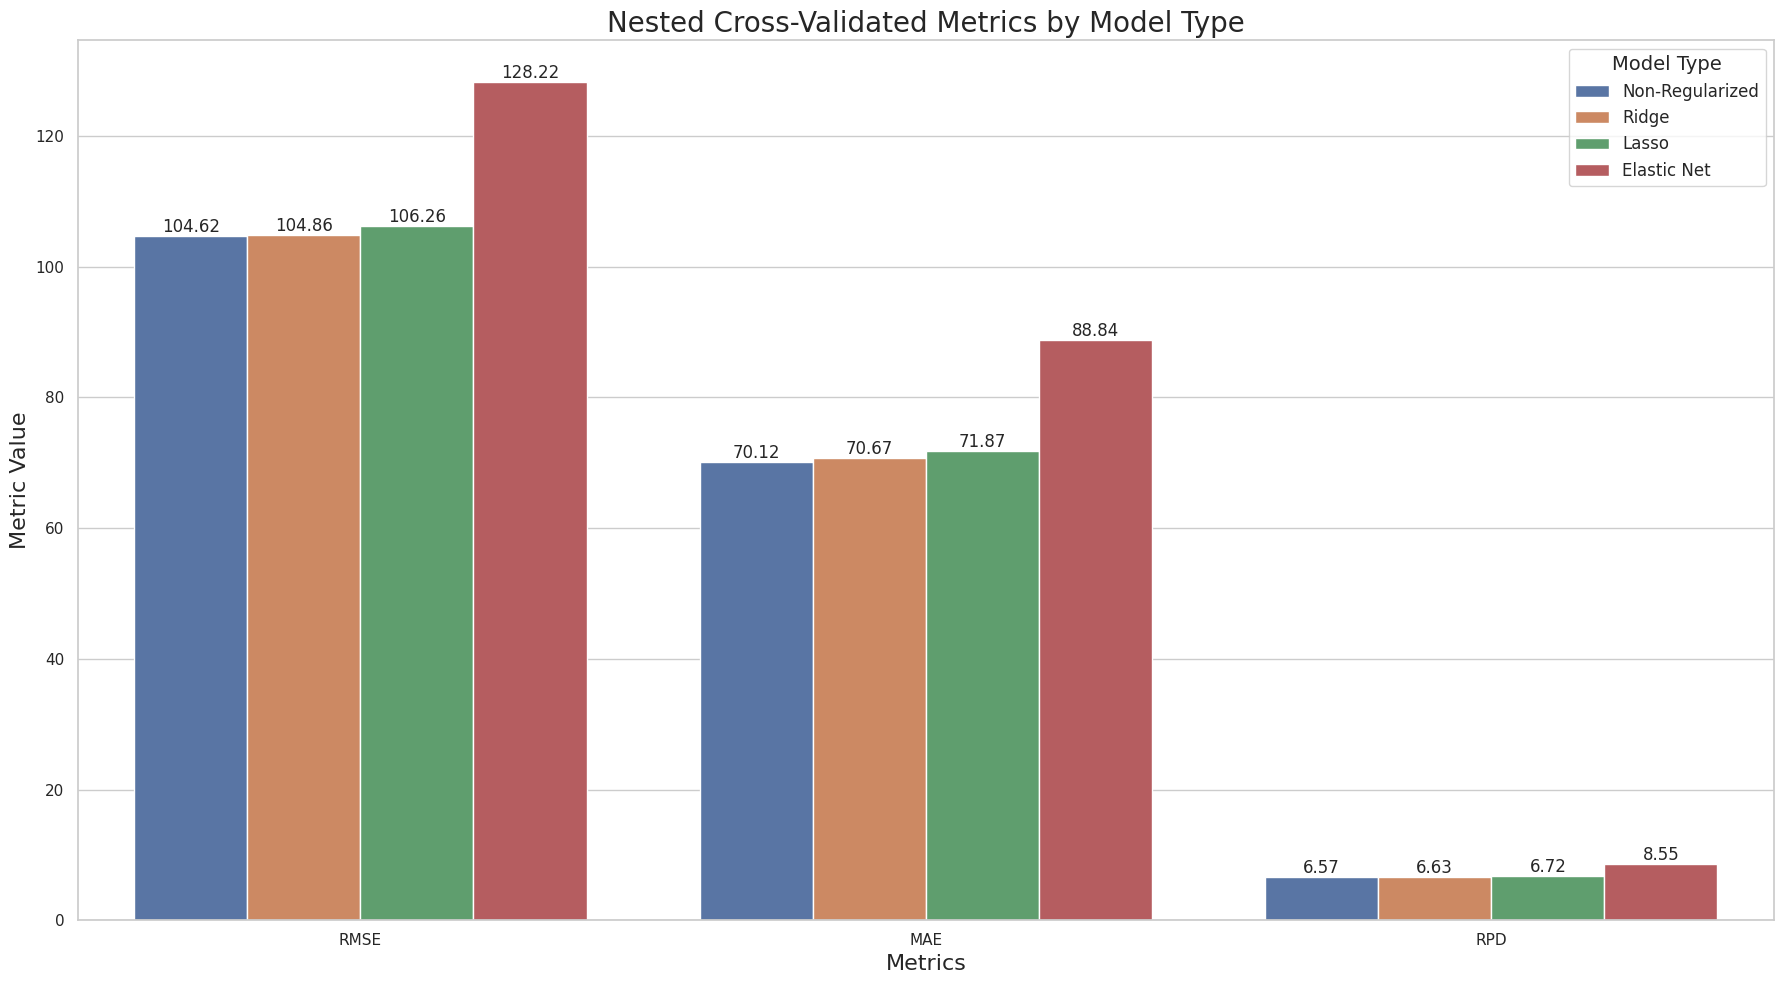

In [ ]:
# Execute the workflow
if __name__ == "__main__":
    main(search_method='random')